In [16]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import json
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from typing import Dict, Union, List, Any
import shared.utils as su
from utils.model import transform_pixel_values
from utils.video import read_frames_decord
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)

In [ ]:
from models.modeling_encoders import AutoEncoder

# model_id = '/work/piyush/pretrained_checkpoints/Tarsier-7b'
# model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint"
# model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint"
model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_10000-seed_42/merged_checkpoint/"
encoder = AutoEncoder.from_pretrained(model_id, device_map='cuda:0')
su.misc.num_params(encoder.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_10000-seed_42/merged_checkpoint/
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Load MSRVTT

In [17]:
data_root = "/scratch/shared/beegfs/piyush/datasets/MSRVTT"
data = su.io.load_json(f"{data_root}/annotation/msrvtt_test_1k.json")
df = pd.DataFrame(data)
video_dir = f"{data_root}/videos/all/"

In [18]:
df['video_path'] = df.video.apply(lambda x: f"{video_dir}/{x}")
df['video_path'].apply(os.path.exists).mean()

1.0

### Compute features

In [19]:
def encode_vision_custom_prompt(encoder, pixel_values, prompt):

    pixel_values = transform_pixel_values(pixel_values) # [B, T, C, H, W]
    nframes = pixel_values.shape[1]

    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    vision_embs = []

    for frames in batched_frames:
        input_prompt = prompt.replace("<video>", "<image>"*len(frames))
        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        vision_embs.append(outputs.hidden_states[0][-1][:, -1, :])
    
    vision_embs = torch.cat(vision_embs)
    return vision_embs


def encode_text_custom_prompt(encoder, text, prompt):

    if isinstance(text, str):
        text = [text]
    
    prompts = [prompt.replace('<sent>', t) for t in text]

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    text_embs = []

    for p in prompts:
        text_inputs = encoder.processor.get_text_inputs(p)
        inputs = {
            "input_ids": text_inputs,
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        text_embs.append(outputs.hidden_states[0][-1][:, -1, :])
    
    text_embs = torch.cat(text_embs)
    return text_embs


def postprocess_embed(z):
    return torch.nn.functional.normalize(z, dim=-1).cpu().float().squeeze(0)

In [20]:
def gather_embeddings(text_captions: list, video_paths: list, prompt_video: str, prompt_text: str):
    
    texts_embed = {}
    for text in su.log.tqdm_iterator(text_captions, desc='Computing text features'):
        with torch.no_grad():
            zt = encode_text_custom_prompt(encoder, text, prompt=prompt_text)
            zt = postprocess_embed(zt)
        texts_embed[text] = zt
    
    
    video_embed = {}
    for video_path in su.log.tqdm_iterator(video_paths, desc='Computing video features'):
        with torch.no_grad():
            video_tensor = read_frames_decord(video_path, 8).unsqueeze(0)
            zv = encode_vision_custom_prompt(encoder, video_tensor, prompt=prompt_video)
            zv = postprocess_embed(zv)
        video_embed[video_path] = zv
    
    return video_embed, texts_embed

In [21]:
captions = df.caption.tolist()
video_paths = df.video_path.tolist()
len(captions), len(video_paths)

(1000, 1000)

In [22]:
NO_EOL_VIDEO = "USER: <video>\nASSISTANT: "
NO_EOL_TEXT = "USER: <sent>\nASSISTANT: "

video_embed_no_eol, texts_embed_no_eol = gather_embeddings(
    text_captions=captions,
    video_paths=video_paths,
    prompt_video=NO_EOL_VIDEO,
    prompt_text=NO_EOL_TEXT,
)
len(video_embed_no_eol), len(texts_embed_no_eol)

Computing text features:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing video features:   0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 995)

In [23]:
video_embed_eol, texts_embed_eol = gather_embeddings(
    text_captions=captions,
    video_paths=video_paths,
    prompt_video=encoder.video_eol_prompt,
    prompt_text=encoder.text_eol_prompt,
)
len(video_embed_eol), len(texts_embed_eol)

Computing text features:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing video features:   0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 995)

### Visualise

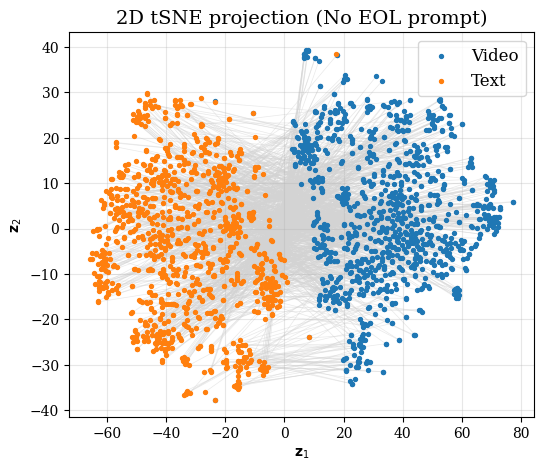

In [26]:
_video_embeds = video_embed_no_eol
_texts_embeds = texts_embed_no_eol
title_suffix = "No EOL prompt"
# save_path = "../figures/tara+tarsier-msrvtt-no_eol.pdf"
save_path = "../figures/tarsier-no_ego4d-msrvtt-no_eol.pdf"

# _video_embeds = video_embed_eol
# _texts_embeds = texts_embed_eol
# title_suffix = "With EOL prompt"
# # save_path = "../figures/tara+tarsier-msrvtt-with_eol.pdf"
# save_path = "../figures/tarsier-no_ego4d-msrvtt-with_eol.pdf"

target_col = 'caption'


ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
Z = torch.concatenate([ZV, ZT], dim=0)
z = su.visualize.reduce_dim(Z, method='tsne')
Z.shape, z.shape

vid2text = {}
for f in _video_embeds:
    vid2text[f] = df[df.video_path == f].iloc[0][target_col]
len(vid2text)

# Create mappings from video/text to their index in z
video_list = list(_video_embeds.keys())
text_list = list(_texts_embeds.keys())

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Draw matching lines first (so they appear behind the points)
for i, f in enumerate(video_list):
    matched_text = vid2text[f]
    if matched_text in text_list:
        j = text_list.index(matched_text)
        # Draw line from video point to text point
        ax.plot([z[i, 0], z[len(ZV) + j, 0]], 
                [z[i, 1], z[len(ZV) + j, 1]], 
                color='lightgray', linewidth=0.5, alpha=0.5, zorder=1)

# Draw scatter points on top
ax.scatter(z[:len(ZV), 0], z[:len(ZV), 1], s=8, label='Video', zorder=2)
ax.scatter(z[len(ZV):, 0], z[len(ZV):, 1], s=8, label='Text', zorder=2)

ax.grid(alpha=0.3)
ax.set_xlabel("$\\mathbf{z}_{1}$")
ax.set_ylabel("$\\mathbf{z}_{2}$")
ax.legend(fontsize=12)
ax.set_title(f"2D tSNE projection ({title_suffix})", fontsize=14)
plt.savefig(save_path, bbox_inches='tight')
plt.show()